# Bycicle power meter case of study

Open the dataset bike_rides.csv with the following commands:
```
import pandas as pd

cycling = pd.read_csv("bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data
```

A detailed description of this dataset is given in the appendix. As a reminder, the problem we are trying to solve with this dataset is to use measurements from cheap sensors (GPS, heart-rate monitor, etc.) in order to predict a cyclist power. Power can indeed be recorded via a cycling power meter device, but this device is rather expensive.

Instead of using blindly machine learning, we will first introduce some flavor of classic mechanics: the Newton's second law.

$$P_{meca}=(\frac{1}{2}ρ.SC_x.Va^2+C_r.mg.cos α+mg.sin α+ma)V_d$$

where $ρ$ is the air density in kg.m$^{−3}$, S is frontal surface of the cyclist in m$^2$, $C_x$ is the drag coefficient, $V_a$ is the air speed in m.s$^{−1}$, $C_r$ is the rolling coefficient, $m$ is the mass of the rider and bicycle in kg, $g$ is the standard acceleration due to gravity which is equal to 9.81 m.s$^{−2}$, $α$ is the slope in radian, $V_d$ is the rider speed in m.s$^{−1}$, and $a$ is the rider acceleration in m.s$^{−2}$.

This equation might look a bit complex at first but we can explain with words what the different terms within the parenthesis are:

* the first term is the power that a cyclist is required to produce to fight wind
* the second term is the power that a cyclist is required to produce to fight the rolling resistance created by the tires on the floor
* the third term is the power that a cyclist is required to produce to go up a hill if the slope is positive. If the slope is negative the cyclist does not need to produce any power to go forward
* the fourth and last term is the power that a cyclist requires to change his speed (i.e. acceleration).

We can simplify the model above by using the data that we have at hand. It would look like the following.

$$P_{meca}=β_1V^3_d+β_2V_d+β_3sin(α)V_d+β_4aV_d$$

This model is closer to what we saw previously: it is a linear model trained on a non-linear feature transformation. We will build, train and evaluate such a model as part of this exercise. Thus, you need to:

* create a new data matrix containing the cube of the speed, the speed, the speed multiplied by the sine of the angle of the slope, and the speed multiplied by the acceleration. To compute the angle of the slope, you need to take the arc tangent of the slope (`alpha = np.arctan(slope)`). In addition, we can limit ourself to positive acceleration only by clipping to 0 the negative acceleration values (they would correspond to some power created by the braking that we are not modeling here).
* using the new data matrix, create a linear predictive model based on a `sklearn.preprocessing.StandardScaler` and a `sklearn.linear_model.RidgeCV`;
* use a `sklearn.model_selection.ShuffleSplit` cross-validation strategy with only 4 splits (`n_splits=4`) to evaluate the generalization performance of the model. Use the mean absolute error (MAE) as a generalization performance metric. Also, pass the parameter `return_estimator=True` and `return_train_score=True` to answer the subsequent questions. Be aware that the `ShuffleSplit` strategy is a naive strategy and we will investigate the consequence of making this choice in the subsequent questions.


In [24]:
import pandas as pd

cycling = pd.read_csv("bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


# -------------------------------------------------------------------------------------------------------------------

# Question 1
What is the mean value of the column information of $sin(α)V_d$?

1. about -3
2. about -0.3
3. about -0.03
4. about -0.003 *

In [25]:
import numpy as np

data_linear_model = pd.concat(
    {
        'V**3': data['speed'] ** 3,
        'V': data['speed'],
        'V*sin(a)': data['speed']*np.sin(np.arctan(data['slope'])),
        'a*V': data['speed']*data['acceleration'].clip(lower =0)
    },
    axis=1
)

f"{data_linear_model['V*sin(a)'].mean():.3f}"

'-0.003'

solution: 4.

The code allowing to build the data matrix and compute the required mean is the following:
```
import numpy as np

# build the data matrix
data_linear_model = pd.concat(
    {"speed^3": data["speed"] ** 3,
     "speed": data["speed"],
     "speed*sin(alpha)": data["speed"] * np.sin(np.arctan(data["slope"])),
     "speed*acceleration": data["speed"] * data["acceleration"].clip(lower=0)},
    axis=1
)
data_linear_model.mean()["speed*sin(alpha)"]
```

# -------------------------------------------------------------------------------------------------------------------

# Question 2
On average, the Mean Absolute Error on the test sets obtained through cross-validation is closest to:
1. 20 Watts
2. 50 Watts
3. 70 Watts *  
4. 90 Watts

Hint 1: pass `scoring="neg_mean_absolute_error"` to the `cross_validate` function to compute the (negative of) the requested metric.

Hint 2: it is possible to replace the negative acceleration values by 0 using `data["acceleration"].clip(lower=0)`

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

# create the model
linear_model = make_pipeline(StandardScaler(), RidgeCV())

# evaluate the model with cross-validation
cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_linear_model = cross_validate(
    linear_model, data_linear_model, target, cv=cv,
    scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True)
errors = -cv_results_linear_model["test_score"]
print(f"MAE on test sets:\n {errors}\n",
      f"{errors.mean():.3f} mean +/- {errors.std():.3f} std Watts")

MAE on test sets:
 [73.23006461 72.1311734  72.89061823 71.2370263 ]
 72.372 mean +/- 0.767 std Watts


solution: 3.

Here is the code that allows to answer the question:
```
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

# create the model
linear_model = make_pipeline(StandardScaler(), RidgeCV())

# evaluate the model with cross-validation
cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_linear_model = cross_validate(
    linear_model, data_linear_model, target, cv=cv,
    scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True)
errors = -cv_results_linear_model["test_score"]
print(f"MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
```

# -------------------------------------------------------------------------------------------------------------------

# Question 3
Given the model $P_{meca}=β_1V^3_d+β_2V_d+β_3sin(α)V_d+β_4aV_d$ that you created, inspect the weights of the linear models fitted during cross-validation and select the correct statements:


1. $β_1<β_2<β_3$ *
2. $β_3<β_1<β_2$
3. $β_2<β_3<β_1$
4. $β_1<0$
6. $β_2<0$
7. $β_3<0$
8. $β_4<0$
9. All $β_s$ are $> 0$ *

Select all answers that apply

In [27]:
for model in cv_results_linear_model['estimator']:
    print(model[-1].coef_)

[ 5.66427806 32.84904152 80.08105928 10.85618779]
[ 5.68897463 32.83434375 80.99005594 11.34425   ]
[ 6.28736152 32.19112942 80.92397865 11.23297157]
[ 6.18278112 32.4035743  80.61344415 11.27427489]


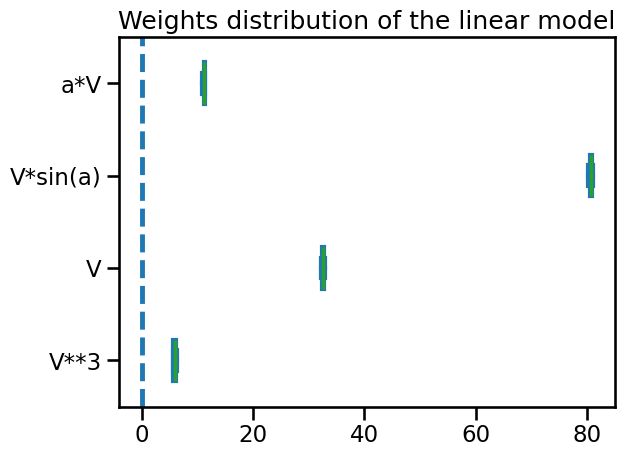

In [28]:
import matplotlib.pyplot as plt
coefs = [
    estimator[-1].coef_ for estimator in cv_results_linear_model["estimator"]]
coefs = pd.DataFrame(coefs, columns=data_linear_model.columns)

ax = coefs.plot.box(vert=False)
ax.axvline(0, -1, 1, linestyle="--")
_ = plt.title("Weights distribution of the linear model")

solution: 1. 8.

We can inspect the coefficients by passing return_estimator in cross_validate call. Then, we can plot the weights distribution with a box plot with the following snippet:
```
import matplotlib.pyplot as plt
coefs = [
    estimator[-1].coef_ for estimator in cv_results_linear_model["estimator"]]
coefs = pd.DataFrame(coefs, columns=data_linear_model.columns)

ax = coefs.plot.box(vert=False)
ax.axvline(0, -1, 1, linestyle="--")
_ = plt.title("Weights distribution of the linear model")
```
All weights are greater than 0. It is not surprising since the coefficients are related to products of positive physical quantities such as the mass of the rider and the bike, gravity, the air density, etc. Indeed, by putting together the first equation and the value of βs, we would expect a relationship that could be close to:

* $β_1 \frac{1}{2}ρ.SC_x$
* $β_2 C_r.mg$
* $β_3  mg$
* $β_4  ma$

This relationship is also explaining why we could have expected $β_1<β_2<β_3$. Indeed, $C_r$ is a small constant so, we could expect $β_2<β_3$. $ρ.SC_x$ are very small values in comparison with $C_r$ or $mg$ and one could have expected $β_1<β_2$.

# -------------------------------------------------------------------------------------------------------------------

# Question 4
Now, we will create a predictive model that uses all `data`, including available sensor measurements such as cadence (the speed at which a cyclist turns pedals measured in rotation per minute) and heart-rate (the number of beat per minute of the heart of the cyclist while exercising). Also, we will use a non-linear regressor, a `sklearn.ensemble.HistGradientBoostingRegressor`. Fix the number of maximum iterations to 1000 (`max_iter=1_000`) and activate the early stopping (`early_stopping=True`). Repeat the previous evaluation using this regressor.

On average, the Mean Absolute Error on the test sets obtained through cross-validation is closest to:
1. 20 Watts
2. 40 Watts *
3. 60 Watts
4. 80 Watts 

In [29]:
from sklearn.ensemble import HistGradientBoostingRegressor
hgbdt = HistGradientBoostingRegressor(max_iter=1_000, early_stopping=True, random_state=42)

# evaluate the model with cross-validation
cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, cv=cv,
    scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True)
errors_hgbdt = -cv_results_hgbdt["test_score"]
print(f"MAE on test sets:\n {errors_hgbdt}\n",
      f"{errors_hgbdt.mean():.3f} mean +/- {errors_hgbdt.std():.3f} std Watts")



MAE on test sets:
 [44.39516221 44.13036203 43.75817    43.06094014]
 43.836 mean +/- 0.502 std Watts


solution: 2.

Here is the code to answer the question:
```
from sklearn.ensemble import HistGradientBoostingRegressor

hgbdt = HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=42
)

cv = ShuffleSplit(n_splits=4, random_state=0)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, cv=cv, scoring="neg_mean_absolute_error",
    return_estimator=True, return_train_score=True, n_jobs=2)

errors = -cv_results_hgbdt["test_score"]
print(f"MAE on test sets:\n {errors}\n",
      f"mean +/- std: {errors.mean():.3f} +/- {errors.std():.3f} Watts")
```
On average, the MAE of this model on the test data is ~44 Watts. Therefore, it seems that the additional features and the change of regressor have a positive impact on the generalization performance.

# -------------------------------------------------------------------------------------------------------------------

# Question 5 
Comparing both the linear model and the histogram gradient boosting model and taking into consideration the train and test MAE obtained via cross-validation, select the correct statements:
1. the generalization performance of the histogram gradient-boosting model is limited by its underfitting
2. the generalization performance of the histogram gradient-boosting model is limited by its overfitting *
3. the generalization performance of the linear model is limited by its underfitting *
4. the generalization performance of the linear model is limited by its overfitting

Select all answers that apply

Hint: look at the values of the train_score and the test_score collected in the dictionaries returned by the cross_validate function.

In [30]:
errors_SS_lm = -cv_results_linear_model["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_SS_lm.mean():.3f} +/- {errors_SS_lm.std():.3f} Watts")
errors_SS_lm = -cv_results_linear_model["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_SS_lm.mean():.3f} +/- {errors_SS_lm.std():.3f} Watts")

errors_SS_hgbdt = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} +/- {errors_SS_hgbdt.std():.3f} Watts")
errors_SS_hgbdt = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} +/- {errors_SS_hgbdt.std():.3f} Watts")

Linear model - MAE on train sets:	 72.479 +/- 0.096 Watts
Linear model - MAE on test sets:	 72.372 +/- 0.767 Watts
Histogram GBDT - MAE on train sets:	 40.561 +/- 0.686 Watts
Histogram GBDT - MAE on test sets:	 43.836 +/- 0.502 Watts


solution: 2. 3.

To answer we need to print the train and test error for both models:
```
errors_SS_lm = -cv_results_linear_model["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_SS_lm.mean():.3f} +/- {errors_SS_lm.std():.3f} Watts")
errors_SS_lm = -cv_results_linear_model["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_SS_lm.mean():.3f} +/- {errors_SS_lm.std():.3f} Watts")

errors_SS_hgbdt = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} +/- {errors_SS_hgbdt.std():.3f} Watts")
errors_SS_hgbdt = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_SS_hgbdt.mean():.3f} +/- {errors_SS_hgbdt.std():.3f} Watts")
```
The output would be something similar to:

Out: ```Linear model - MAE on train sets: 72.479 +/- 0.096 Watts Linear model - MAE on test sets: 72.372 +/- 0.767 Watts Histogram GBDT - MAE on train sets: 40.561 +/- 0.686 Watts Histogram GBDT - MAE on test sets: 43.836 +/- 0.502 Watts```

With the histogram gradient boosting, the testing error is higher than thetraining error. This symptomatic of a model capable of overfitting. The testing and training error of the linear model are very close. However, the errors are much higher than the histogram gradient boosting. The linear model is clearly underfitting.

# -------------------------------------------------------------------------------------------------------------------

# Question 6
In the previous cross-validation, we made the choice of using a `ShuffleSplit` cross-validation strategy. It means that randomly selected samples were selected as testing set ignoring any time dependency between the lines of the dataframe.

We would like to have a cross-validation strategy that takes into account the groups defined by each individual date. Each group corresponds to a bike ride.

How many bike rides are stored in the dataframe `data`? Do not hesitate to look at the hints.

1.  2
2.  3
3.  4 *
4.  5

Hint 1: You can check the unique day in the `DatetimeIndex` (the index of the dataframe `data`). Indeed, we assume that on a given day the rider went cycling at most once per day.

Hint 2: You can access to the date and time of a `DatetimeIndex` using `df.index.date` and `df.index.time`, respectively.

In [31]:
import numpy as np

unique_ride_dates = np.unique(cycling.index.date)
print(f"There are {len(unique_ride_dates)} bike rides")

There are 4 bike rides


solution: 3.

We can inspect the index of the dataframe. The following code snippet allows to count the number of different days appearing in the index of the dataframe.
```
import numpy as np

unique_ride_dates = np.unique(cycling.index.date)
print(f"There are {len(unique_ride_dates)} bike rides")
```

# -------------------------------------------------------------------------------------------------------------------

# Question 7
We would like to have a cross-validation strategy that evaluates the capacity of our model to predict on a completely new bike ride: the samples in the validation set should only come from rides not present in the training set. Therefore, we can use a `LeaveOneGroupOut` strategy: at each iteration of the cross-validation, we will keep a bike ride for the evaluation and use all other bike rides to train our model.

Thus, you concretely need to:
* create a variable called `group` that is a 1D numpy array containing the index of each ride present in the dataframe. Therefore, the length of `group` will be equal to the number of samples in `data`. If we had 2 bike rides, we would expect the indices 0 and 1 in `group` to differentiate the bike ride. You can use `pd.factorize` to encode any Python types into integer indices.
* create a cross-validation object named `cv` using the `sklearn.model_selection.LeaveOneGroupOut` strategy.
* evaluate both the linear and histogram gradient boosting models with this strategy.

Using the previous evaluations (with the `LeaveOneGroupOut` strategy) and looking at the train and test errors for both models, select the correct statements:

1. the generalization performance of the gradient-boosting model is limited by its underfitting
2. the generalization performance of the gradient-boosting model is limited by its overfitting *
3. the generalization performance of the linear model is limited by its underfitting *
4. the generalization performance of the linear model is limited by its overfitting

Select all answers that apply

In [32]:
from sklearn.model_selection import LeaveOneGroupOut

groups, _ = pd.factorize(data_linear_model.index.date)
cv = LeaveOneGroupOut()

cv_results_linear_model = cross_validate(
    linear_model, data_linear_model, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)

errors_LOGO_lm = -cv_results_linear_model["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")
errors_LOGO_lm = -cv_results_linear_model["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")

errors_LOGO_hgbdt = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")
errors_LOGO_hgbdt = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")

Linear model - MAE on train sets:	 72.249 +/- 2.247 Watts
Linear model - MAE on test sets:	 73.015 +/- 5.779 Watts
Histogram GBDT - MAE on train sets:	 40.131 +/- 1.295 Watts
Histogram GBDT - MAE on test sets:	 49.204 +/- 2.694 Watts


linear model underfits, HGBDT model overfits, with LOGO cv strategy is even wider the gap between the train and the test scores of the last model compared to the SS cv strategy.

solution: 2. 3.

The evaluation using the `LeaveOneGroupOut` is performed with the following code snippet:
```
from sklearn.model_selection import LeaveOneGroupOut

groups, _ = pd.factorize(data_linear_model.index.date)
cv = LeaveOneGroupOut()

cv_results_linear_model = cross_validate(
    linear_model, data_linear_model, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)
cv_results_hgbdt = cross_validate(
    hgbdt, data, target, groups=groups, cv=cv,
    scoring="neg_mean_absolute_error", return_estimator=True,
    return_train_score=True, n_jobs=2)

errors_LOGO_lm = -cv_results_linear_model["train_score"]
print(f"Linear model - MAE on train sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")
errors_LOGO_lm = -cv_results_linear_model["test_score"]
print(f"Linear model - MAE on test sets:\t",
      f"{errors_LOGO_lm.mean():.3f} +/- {errors_LOGO_lm.std():.3f} Watts")

errors_LOGO_hgbdt = -cv_results_hgbdt["train_score"]
print(f"Histogram GBDT - MAE on train sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")
errors_LOGO_hgbdt = -cv_results_hgbdt["test_score"]
print(f"Histogram GBDT - MAE on test sets:\t",
      f"{errors_LOGO_hgbdt.mean():.3f} +/- {errors_LOGO_hgbdt.std():.3f} Watts")
```
The output should be similar to:

Out : `Linear model - MAE on train sets: 72.249 +/- 2.247 Watts Linear model - MAE on test sets: 73.015 +/- 5.779 Watts Histogram GBDT - MAE on train sets: 40.131 +/- 1.295 Watts Histogram GBDT - MAE on test sets: 49.204 +/- 2.694 Watts`

Regarding model under- and over-fitting, we observe the same behaviour as with the `ShuffleSplit strategy`: the linear model is still limited by underfitting while the histogram gradient boosting regressor is still overfitting.

We also see that the histogram gradient boosting regressor is more clearly overfitting with the `LeaveOneGroupOut` cross-validation strategy as the gap between train and test scores is even wider than measured with the `ShuffleSplit` strategy.

Thus, even if the linear model is modelling the true physical problem, it probably suffers from shortcomings imposed by missing measurements (for instance wind speed) and by the uncertainty of some measurements (for instance GPS error). As a result, the linear model is not as accurate as the histogram gradient boosting regressor that has access to external measurements. The additional information, such as the heart-rate and the cadence, attenuate the previous shortcomings.

# -------------------------------------------------------------------------------------------------------------------

# Question 8
In this case we cannot compare cross-validation scores fold-to-fold as the folds are not aligned (they are not generated by the exact same strategy). Instead, compare the mean of the cross-validation test errors in the evaluations of the **linear model** to select the correct statement.
When using the `ShuffleSplit` strategy, the mean test error:

1. is greater than the LeaveOneGroupOut mean test error by more than 3 Watts, i.e. ShuffleSplit is giving over-pessimistic results
2. differs from the LeaveOneGroupOut mean test error by less than 3 Watts, i.e. both cross-validation strategies are equivalent *
3. is lower than the LeaveOneGroupOut mean test error by more than 3 Watts, i.e. ShuffleSplit is giving over-optimistic results


In [33]:
print(
    "LM with LeaveOneGroupOut has a bigger test error than LM with ShuffleSplit by "
    f"{errors_LOGO_lm.mean() - errors_SS_lm.mean()}"
    " Watts."
)

LM with LeaveOneGroupOut has a bigger test error than LM with ShuffleSplit by 0.6425546178643629 Watts.


solution: b)

We can use the following code to compare the estimates of the generalization performance of linear models with both cv strategies:
```
print(
    "LM with LeaveOneGroupOut has a bigger test error than LM with ShuffleSplit by "
    f"{errors_LOGO_lm.mean() - errors_SS_lm.mean()}"
    " Watts."
)
```

# -------------------------------------------------------------------------------------------------------------------

# Question 9
Compare the mean of the cross-validation test errors in the evaluations of the **gradient-boosting model** to select the correct statement.

When using the `ShuffleSplit` strategy, the mean test error:
1. is greater than the `LeaveOneGroupOut` mean test error by more than 3 Watts, i.e. `ShuffleSplit` is giving over-pessimistic results
2. differs from the `LeaveOneGroupOut` mean test error by less than 3 Watts, i.e. both cross-validation strategies are equivalent
3. is lower than the `LeaveOneGroupOut` mean test error by more than 3 Watts, i.e. `ShuffleSplit` is giving over-optimistic results *


In [34]:
print(
    "HGBDT with LeaveOneGroupOut has a bigger test error than HGBDT with ShuffleSplit by "
    f"{errors_LOGO_hgbdt.mean() - errors_SS_hgbdt.mean()}"
    " Watts."
)

HGBDT with LeaveOneGroupOut has a bigger test error than HGBDT with ShuffleSplit by 5.367504740249601 Watts.


solution: 3.

We can use the following code to compare the HGBDT models with both cv strategies:
```
print(
    "HGBDT with LeaveOneGroupOut has a bigger test error than HGBDT with ShuffleSplit by "
    f"{errors_LOGO_hgbdt.mean() - errors_SS_hgbdt.mean()}"
    " Watts."
)
```
`ShuffleSplit` estimates a lower generalization error than the error measured by `LeaveOneGroupOut` for the gradient boosting model.

The `LeaveOneGroupOut` strategy is closer to the actual setting encountered when putting the model in production, we can conclude that the generalization performance provided by the `ShuffleSplit` cross-validation strategy was over-optimistic by estimating a lower average test error than what we would observe on future bike rides.

It is interesting to note that we do not see this behaviour for the linear model. The reason is that our linear model is underfitting.

# -------------------------------------------------------------------------------------------------------------------

# Question 10
Compare more precisely the errors estimated through cross-validation and select the correct statement:
1. in general, the standard deviation of the train and test errors increased using the `LeaveOneGroupOut` cross-validation *
2. in general, the standard deviation of the train and test errors decreased using the `LeaveOneGroupOut` cross-validation 

solution: 1.

We observe a higher standard deviation of the test MAE when it is computed by respecting the ride dependency structure using `LeaveOneGroupOut`: we can see that the third fold has a low train error and a much higher test error than for the other folds.

The reason can be found by plotting histograms of the target variable independently for each ride and observe that one ridge has significantly higher power values with a long and steep slope.

# -------------------------------------------------------------------------------------------------------------------

# Question 11 

Now, we will go more into details by picking a single ride for the testing and analyse the predictions of the models for this test ride. To do so, we can reuse the `LeaveOneGroupOut` cross-validation object in the following manner:
```
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]
```
Now, fit both the linear model and the histogram gradient boosting regressor models on the training data and collect the predictions on the testing data. Make a scatter plot where on the x-axis, you will plot the measured powers (true target) and on the y-axis, you will plot the predicted powers (predicted target). Do two separated plots for each model.

By analysing the plots, select the correct statements:

1. the linear regressor tends to under-predict samples with high power * 
2. the linear regressor tends to over-predict samples with high power
3. the linear regressor makes catastrophic predictions for samples with power close to zero *
4. the histogram gradient boosting regressor tends to under-predict samples with high power *
5. the histogram gradient boosting regressor tends to over-predict samples with high power
6. the histogram gradient boosting makes catastrophic predictions for samples with power close to zero

Select all answers that apply


# -------------------------------------------------------------------------------------------------------------------
 ## Mi respuesta ##
# -------------------------------------------------------------------------------------------------------------------

In [35]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=groups))[0]

data_linear_model_train = data_linear_model.iloc[train_indices]
data_linear_model_test = data_linear_model.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

linear_model.fit(data_linear_model_train,target_train)
hgbdt.fit(data_train, target_train)


predict_lm = linear_model.predict(data_linear_model_test)
predict_hgbdt = hgbdt.predict(data_test)


In [36]:
predict_hgbdt.min(), predict_hgbdt.max()

(-30.563210761681937, 543.3415477920107)

In [37]:
predict_lm.min(), predict_lm.max()

(-292.5996159978139, 462.6343238474858)

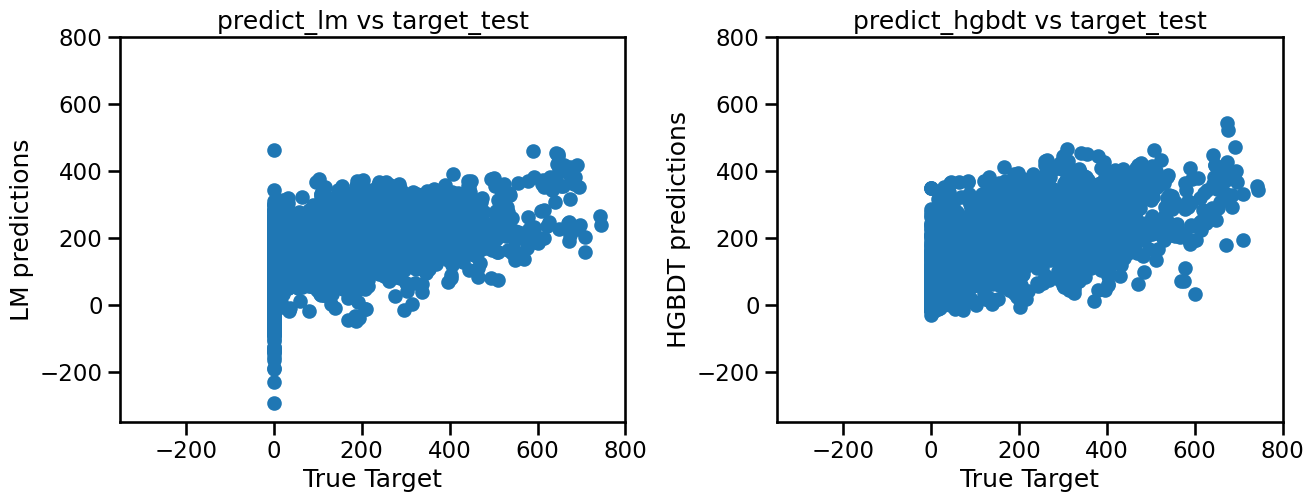

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(target_test, predict_lm)
axs[0].set_xlabel('True Target')
axs[0].set_ylabel('LM predictions')
axs[0].set_title('predict_lm vs target_test')

axs[1].scatter(target_test, predict_hgbdt)
axs[1].set_xlabel('True Target')
axs[1].set_ylabel('HGBDT predictions')
axs[1].set_title('predict_hgbdt vs target_test')
fig.subplots_adjust(wspace=0.3)


axs[0].set_ylim([-350, 800])
axs[1].set_ylim([-350, 800])
axs[0].set_xlim([-350, 800])
axs[1].set_xlim([-350, 800])


plt.show()




# -------------------------------------------------------------------------------------------------------------------
## Respuesta oficial ##
# -------------------------------------------------------------------------------------------------------------------

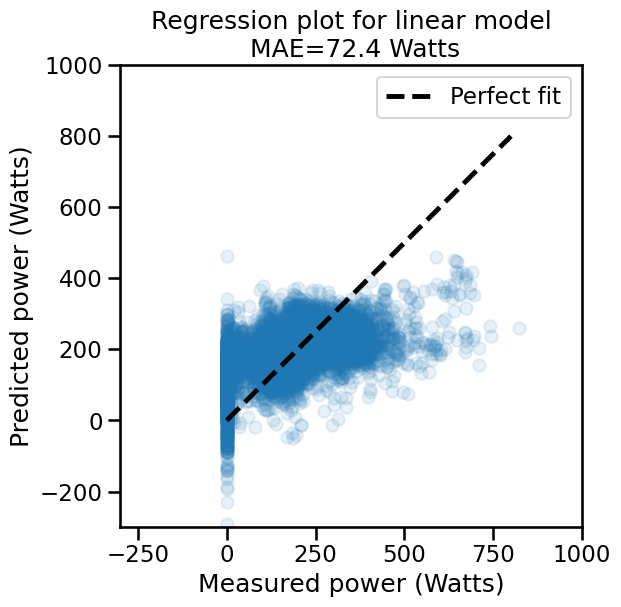

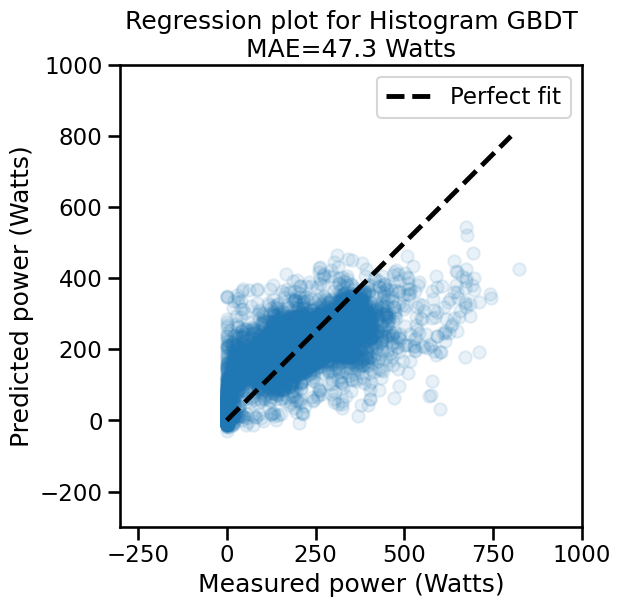

In [39]:
from sklearn.metrics import mean_absolute_error

# fit models and collect predictions
linear_model.fit(data_linear_model_train, target_train)
target_predicted_linear_model = linear_model.predict(data_linear_model_test)

hgbdt.fit(data_train, target_train)
target_predicted_hgbdt = hgbdt.predict(data_test)

# compute errors
mae_linear_model = mean_absolute_error(target_test,
                                       target_predicted_linear_model)
mae_hgbdt = mean_absolute_error(target_test, target_predicted_hgbdt)

# make regression plots
plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_linear_model, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
_ = plt.title(f"Regression plot for linear model\n "
              f"MAE={mae_linear_model:.1f} Watts")

plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_hgbdt, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
_ = plt.title(f"Regression plot for Histogram GBDT\n"
              f"MAE={mae_hgbdt:.1f} Watts")

solutions: 1. 3. 4.

We can fit the models, collect the predictions, and make the plots with the following code snippet:
```
from sklearn.metrics import mean_absolute_error

# fit models and collect predictions
linear_model.fit(data_linear_model_train, target_train)
target_predicted_linear_model = linear_model.predict(data_linear_model_test)

hgbdt.fit(data_train, target_train)
target_predicted_hgbdt = hgbdt.predict(data_test)

# compute errors
mae_linear_model = mean_absolute_error(target_test,
                                       target_predicted_linear_model)
mae_hgbdt = mean_absolute_error(target_test, target_predicted_hgbdt)

# make regression plots
plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_linear_model, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
_ = plt.title(f"Regression plot for linear model\n "
              f"MAE={mae_linear_model:.1f} Watts")

plt.figure(figsize=(6, 6))
plt.scatter(target_test, target_predicted_hgbdt, alpha=0.1)
plt.plot([0, 800], [0, 800], color="black", linestyle="--",
         label="Perfect fit")
plt.legend()
plt.axis("square")
plt.xlabel("Measured power (Watts)")
plt.ylabel("Predicted power (Watts)")
plt.xlim(-300, 1000)
plt.ylim(-300, 1000)
_ = plt.title(f"Regression plot for Histogram GBDT\n"
              f"MAE={mae_hgbdt:.1f} Watts")
```
Let\'s start by looking at the samples with high power. We see that both the linear model and the histogram gradient boosting regressor always predict power below the measured power. Indeed, high power samples correspond to sprints effort. When measuring speed and acceleration, there is a sort of delay to observe this change while measuring the power directly apply on the pedals will not suffer from such issue.

On the other hand, we see that the linear model predicts catastrophic negative power for samples with a power of 0 Watt. This is due to our modeling. Indeed, the power based on the change of kinetic energy (power needed to accelerate or decelerate) is producing such artifacts. Indeed, we do not model the power loss introduced by heat dissipation when braking to reduce the speed of the bike (to take a bend for instance) and therefore, we get non-sense value for samples with low power. The histogram gradient boosting regressor uses instead the cadence since 0 rpm (rotation per minute) will be linked with 0 Watt produced.

# -------------------------------------------------------------------------------------------------------------------

# Question 12
Now select a portion of the testing data using the following code:
```
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]
```
It allows to select data from 5.00 pm until 5.05 pm. Used the previous fitted models (linear and gradient-boosting regressor) to predict on this portion of the test data. Draw on the same plot the true targets and the predictions of each model.

By using the previous plot, select the correct statements:
1. the linear model is more accurate than the histogram gradient boosting regressor
2. the histogram gradient boosting regressor is more accurate than the linear model *


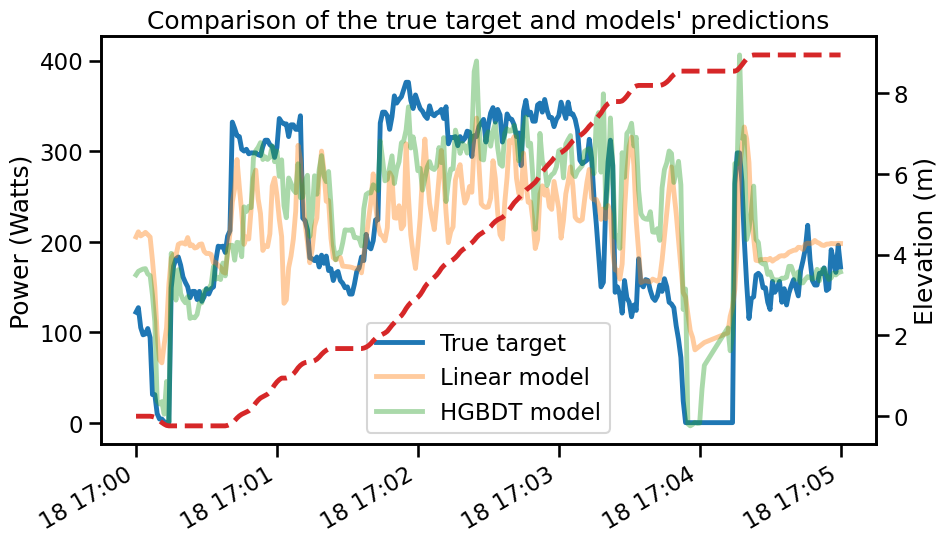

In [40]:
# extract the data and make the prediction
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

target_predicted_linear_model = linear_model.predict(
    data_test_linear_model_subset)
target_predicted_hgbdt = hgbdt.predict(data_test_subset)

# make the plot
ax = target_test_subset.plot(label="True target", figsize=(10, 6))
ax.plot(target_test_subset.index, target_predicted_linear_model,
        label="Linear model", alpha=0.4)
ax.plot(target_test_subset.index, target_predicted_hgbdt, label="HGBDT model", alpha=0.4)
ax.set_ylabel("Power (Watts)")
plt.legend()

# In addition, we add the elevation to show that the data were acquired in a
# hill. This part of the answer was optional.
ax_elevation = ax.twinx()
ax_elevation.plot(target_test_subset.index, data_test_subset["slope"].cumsum(),
                  color="tab:red", linestyle="--")
ax_elevation.set_ylabel("Elevation (m)")

_ = plt.title("Comparison of the true target and models' predictions")

solution: 2.

To produce the desired plots, we can use the following code snippet:
```
# extract the data and make the prediction
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data_test_linear_model_subset = data_linear_model_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

target_predicted_linear_model = linear_model.predict(
    data_test_linear_model_subset)
target_predicted_hgbdt = hgbdt.predict(data_test_subset)

# make the plot
ax = target_test_subset.plot(label="True target", figsize=(10, 6))
ax.plot(target_test_subset.index, target_predicted_linear_model,
        label="Linear model")
ax.plot(target_test_subset.index, target_predicted_hgbdt, label="HGBDT model")
ax.set_ylabel("Power (Watts)")
plt.legend()

# In addition, we add the elevation to show that the data were acquired in a
# hill. This part of the answer was optional.
ax_elevation = ax.twinx()
ax_elevation.plot(target_test_subset.index, data_test_subset["slope"].cumsum(),
                  color="tab:red", linestyle="--")
ax_elevation.set_ylabel("Elevation (m)")

_ = plt.title("Comparison of the true target and models' predictions")
```
We see that the linear model has predictions that are more off from the true target than the predictions from the histogram gradient boosting regressor. While the histogram gradient boosting regressor is able to make abrupt changes of the power, the linear model is unable to predict abrupt changes and need time to output the level of true power.

Again the comparatively bad performance of the linear regression model trained on the physically meaningful features does not necessarily stem from errors in the feature engineering but might come from the GPS measurement errors that prevent a precise estimation of short changes in the speed and acceleration.

The gradient boosting model might be able to workaround those limitations of the GPS errors via the more precise heart rate and cadence measurements.

# -------------------------------------------------------------------------------------------------------------------